In [7]:
import numpy as np
import matplotlib.pyplot as plt

#construct a simple bandit environment
class Bandit:
  def __init__(self, k = 4, true_mean = 0, true_std = 1, reward_std = 1):

    self.size = k # number of bandits
    self.q = np.random.normal(true_mean, true_std, k) #generate true q*

  def reward(self, action):
    return np.random.normal(self.q[action], 1) #generate random reward for each action a

#tie-breaking rule: do not use np.argmax
def argmax(arr):
  return np.random.choice([idx for idx in range(len(arr)) if arr[idx] == arr.max()])

In [8]:
# bandit algorithm: epsilon-greedy, optimistic initial value, and upper confidence bound
def simple_bandit(env, n, epsilon, init = 0, UCB = False, c_UCB = 2):
  #record the history
  hist_A = []
  hist_R = []

  Q = np.ones(env.size)*init #optimistic initial value
  N = np.zeros(env.size)

  if not(UCB):
    #iteration
    for i in range(n):
      #epsilon-greedy algorithm
      if np.random.rand() > epsilon:
          A = argmax(Q)
      else:
          A = np.random.randint(env.size)
      #receive a reward
      R = env.reward(A)
      #incremental implementation
      N[A] += 1
      Q[A] += (1/N[A]) * (R - Q[A])
      #save the current action and reward
      hist_A.append(A)
      hist_R.append(R)

  else:
    N = N + 0.00001 #avoding zero-division
    #iteration
    for i in range(n):
        #upper confidence bound
        UCB = c_UCB*np.sqrt(np.log(n)/N)
        A = np.argmax([q for q in Q + UCB])
        R = env.reward(A)

        N[A] += 1
        #undo N treatment if it avoids zero
        if N[A] == 1.00001:
            N[A] -= 0.00001
        #incremental implementation
        Q[A] += (1/N[A]) * (R - Q[A])
        #save the current action and reward
        hist_A.append(A)
        hist_R.append(R)

  return Q, np.array(hist_A), np.array(hist_R)

In [6]:
#Fix the random seed number
np.random.seed(1)

#Create bandit problem
env = Bandit() #default parameters: 10 arms / q ~ N(0, 1) / r ~ N(q, 1)

#Finding optimal q (not known for the agent)
for i, true_q in enumerate(env.q):
    print('Bandit %d true q: %.2f'%(i+1, true_q))
print('-'*20)
print('Optimal action is', np.argmax(env.q)+1)

Bandit 1 true q: 1.62
Bandit 2 true q: -0.61
Bandit 3 true q: -0.53
Bandit 4 true q: -1.07
--------------------
Optimal action is 1


In [ ]:
#1. Simple epsilon-greedy algorithm

ep0_A, ep0_R = [], []      # epsilon=0, greedy
ep01_A, ep01_R = [], []    # epsilon=0.1
ep001_A, ep001_R = [], []  # epsilon=0.01

#experimental setup
n_exp = 2000 #number of experiment
n_trial = 1000 #number of trial per experiment

for i in range(1, n_exp+1):
  Q, hist_A, hist_R = simple_bandit(env, n=n_trial, epsilon=0)
  ep0_A.append(hist_A)
  ep0_R.append(hist_R)

  Q, hist_A, hist_R = simple_bandit(env, n=n_trial, epsilon=0.1)
  ep01_A.append(hist_A)
  ep01_R.append(hist_R)

  Q, hist_A, hist_R = simple_bandit(env, n=n_trial, epsilon=0.01)
  ep001_A.append(hist_A)
  ep001_R.append(hist_R)

  if i % 100 == 0 and i > 0:
    print('{}/{}'.format(i, n_exp), '[', '*'*int(i/100), '-'*int((n_exp-i)/100), ']')

ep0_A, ep0_R = np.array(ep0_A), np.array(ep0_R)
ep01_A,ep01_R = np.array(ep01_A), np.array(ep01_R)
ep001_A, ep001_R = np.array(ep001_A), np.array(ep001_R)

100/2000 [ * ------------------- ]
200/2000 [ ** ------------------ ]
300/2000 [ *** ----------------- ]
400/2000 [ **** ---------------- ]
500/2000 [ ***** --------------- ]
600/2000 [ ****** -------------- ]
700/2000 [ ******* ------------- ]
800/2000 [ ******** ------------ ]
900/2000 [ ********* ----------- ]
1000/2000 [ ********** ---------- ]
1100/2000 [ *********** --------- ]
1200/2000 [ ************ -------- ]
1300/2000 [ ************* ------- ]
1400/2000 [ ************** ------ ]
1500/2000 [ *************** ----- ]
1600/2000 [ **************** ---- ]
1700/2000 [ ***************** --- ]
1800/2000 [ ****************** -- ]
1900/2000 [ ******************* - ]
2000/2000 [ ********************  ]


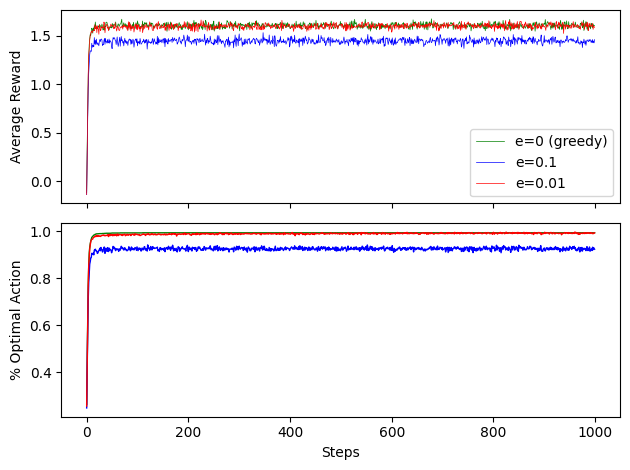

In [ ]:
avg_ep0_R = np.average(ep0_R, axis=0)
avg_ep01_R = np.average(ep01_R, axis=0)
avg_ep001_R = np.average(ep001_R, axis=0)

max_A = np.argmax(env.q)
opt_ep0_A = np.average(ep0_A==max_A, axis=0)
opt_ep01_A = np.average(ep01_A==max_A, axis=0)
opt_ep001_A = np.average(ep001_A==max_A, axis=0)

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(avg_ep0_R,   linewidth=0.5, color='green', label='e=0 (greedy)')
ax.plot(avg_ep01_R,  linewidth=0.5, color='blue',  label='e=0.1')
ax.plot(avg_ep001_R, linewidth=0.5, color='red',   label='e=0.01')
ax.set_ylabel('Average Reward')
ax.xaxis.set_ticklabels([])
ax.legend()

ax = fig.add_subplot(212)
ax.plot(opt_ep0_A,   linewidth=1., color='green', label='e=0 (greedy)')
ax.plot(opt_ep01_A,  linewidth=1., color='blue',  label='e=0.1')
ax.plot(opt_ep001_A, linewidth=1., color='red',   label='e=0.01')
ax.set_xlabel('Steps'); ax.set_ylabel('% Optimal Action')

plt.tight_layout()
plt.show()

In [ ]:
#2. Optimistic initial value
A_OPT, R_OPT = [], []      # eps=0, greedy, optimistic

for i in range(1, n_exp+1):
  Q, hist_A, hist_R = simple_bandit(env, n=n_trial, epsilon=0, init = 10)
  A_OPT.append(hist_A);
  R_OPT.append(hist_R);

  if i % 100 == 0 and i > 0:
    print('{}/{}'.format(i, n_exp), '[', '*'*int(i/100), '-'*int((n_exp-i)/100), ']')

A_OPT, R_OPT = np.array(A_OPT), np.array(R_OPT)

100/2000 [ * ------------------- ]
200/2000 [ ** ------------------ ]
300/2000 [ *** ----------------- ]
400/2000 [ **** ---------------- ]
500/2000 [ ***** --------------- ]
600/2000 [ ****** -------------- ]
700/2000 [ ******* ------------- ]
800/2000 [ ******** ------------ ]
900/2000 [ ********* ----------- ]
1000/2000 [ ********** ---------- ]
1100/2000 [ *********** --------- ]
1200/2000 [ ************ -------- ]
1300/2000 [ ************* ------- ]
1400/2000 [ ************** ------ ]
1500/2000 [ *************** ----- ]
1600/2000 [ **************** ---- ]
1700/2000 [ ***************** --- ]
1800/2000 [ ****************** -- ]
1900/2000 [ ******************* - ]
2000/2000 [ ********************  ]


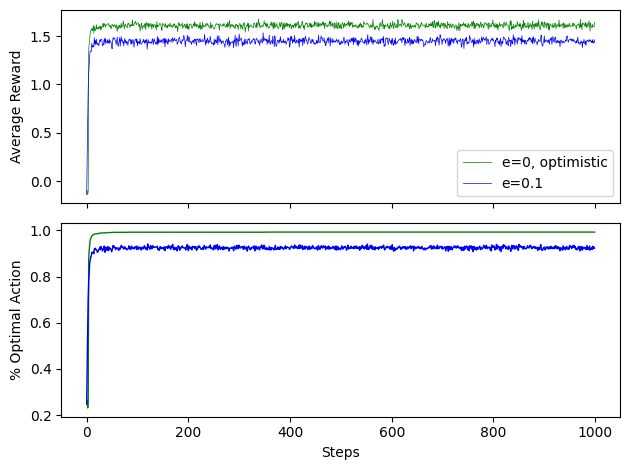

In [ ]:
avg_R_OPT = np.average(R_OPT, axis=0)
opt_A_OPT = np.average(A_OPT==max_A, axis=0)

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(avg_R_OPT,   linewidth=0.5, color='green', label='e=0, optimistic')
ax.plot(avg_ep01_R,  linewidth=0.5, color='blue',  label='e=0.1')
ax.set_ylabel('Average Reward')
ax.xaxis.set_ticklabels([])
ax.legend()

ax = fig.add_subplot(212)
ax.plot(opt_A_OPT,   linewidth=1., color='green', label='e=0, optimistic')
ax.plot(opt_ep01_A,  linewidth=1., color='blue',  label='e=0.1')
ax.set_xlabel('Steps'); ax.set_ylabel('% Optimal Action')

plt.tight_layout()
plt.show()

In [ ]:
#3. upper confidence bound
A_UCB, R_UCB = [], []      # upper-confidence-bound

for i in range(n_exp):
  Q, hist_A, hist_R = simple_bandit(env, n=n_trial, epsilon=0, init = 10, UCB=True, c_UCB = 2)
  A_UCB.append(hist_A);
  R_UCB.append(hist_R);

  if i % 100 == 0 and i > 0:
    print('{}/{}'.format(i, n_exp), '[', '*'*int(i/100), '-'*int((n_exp-i)/100), ']')

A_UCB, R_UCB = np.array(A_UCB), np.array(R_UCB)

100/2000 [ * ------------------- ]
200/2000 [ ** ------------------ ]
300/2000 [ *** ----------------- ]
400/2000 [ **** ---------------- ]
500/2000 [ ***** --------------- ]
600/2000 [ ****** -------------- ]
700/2000 [ ******* ------------- ]
800/2000 [ ******** ------------ ]
900/2000 [ ********* ----------- ]
1000/2000 [ ********** ---------- ]
1100/2000 [ *********** --------- ]
1200/2000 [ ************ -------- ]
1300/2000 [ ************* ------- ]
1400/2000 [ ************** ------ ]
1500/2000 [ *************** ----- ]
1600/2000 [ **************** ---- ]
1700/2000 [ ***************** --- ]
1800/2000 [ ****************** -- ]
1900/2000 [ ******************* - ]


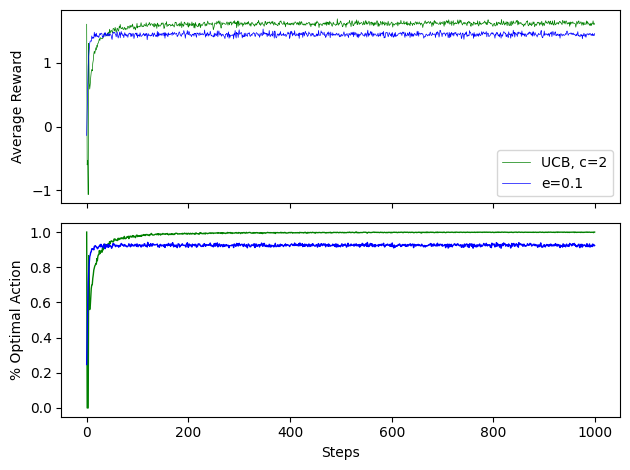

In [ ]:
avg_R_UCB = np.average(R_UCB, axis=0)
opt_A_UCB = np.average(A_UCB==max_A, axis=0)

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(avg_R_UCB,   linewidth=0.5, color='green', label='UCB, c=2')
ax.plot(avg_ep01_R,  linewidth=0.5, color='blue',  label='e=0.1')
ax.set_ylabel('Average Reward')
ax.xaxis.set_ticklabels([])
ax.legend()

ax = fig.add_subplot(212)
ax.plot(opt_A_UCB,   linewidth=1., color='green', label='UCB, c=2')
ax.plot(opt_ep01_A,  linewidth=1., color='blue',  label='e=0.1')
ax.set_xlabel('Steps'); ax.set_ylabel('% Optimal Action')

plt.tight_layout()
plt.show()

In [ ]:
#Gradient bandit algorithm
def gradient_bandit(env, n, alpha, baseline=True):
  hist_A = []
  hist_R = []

  H = np.zeros(env.size)
  avg_R = np.zeros(env.size)
  N = np.zeros(env.size)

  for i in range(n):
    pi = np.array([np.exp(H[i])/np.sum(np.exp(H)) for i in range(env.size)])

    A = np.random.choice(env.size, p = pi)
    R = env.reward(A)

    if baseline:
      for j in range(env.size):
        if j == A:
          H[j] += alpha*(R - avg_R[j])*(1 - pi[j])
        else:
          H[j] -= alpha*(R - avg_R[j])*pi[j]
    else:
      for j in range(env.size):
        if j == A:
          H[j] += alpha*R*(1 - pi[j])
        else:
          H[j] -= alpha*R*pi[j]

    N[A] += 1
    avg_R[A] += 1/N[A]*(R - avg_R[A])

    hist_A.append(A)
    hist_R.append(R)

  return pi, np.array(hist_A), np.array(hist_R)

A_GB_bl, R_GB_bl = [], []      # baseline
A_GB_nbl, R_GB_nbl = [], []    # no baseline

n_trial = 1000

for i in range(2000):
    pi, hist_A, hist_R = gradient_bandit(env, n=n_trial, alpha=0.1)
    pi, A_GB_bl.append(hist_A); R_GB_bl.append(hist_R);

    pi, hist_A, hist_R = gradient_bandit(env, n=1000, alpha=0.1, baseline=False)
    pi, A_GB_nbl.append(hist_A); R_GB_nbl.append(hist_R);

    if i % 100 == 0: print('.', end='')

A_GB_bl, R_GB_bl = np.array(A_GB_bl), np.array(R_GB_bl)
A_GB_nbl, R_GB_nbl = np.array(A_GB_nbl), np.array(R_GB_nbl)

In [ ]:
max_A = np.argmax(env.q)
avg_R_bl = np.average(R_GB_bl, axis=0)
avg_R_nbl = np.average(R_GB_nbl, axis=0)
opt_A_bl = np.average(A_GB_bl==max_A, axis=0)
opt_A_nbl = np.average(A_GB_nbl==max_A, axis=0)

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(avg_R_bl,   linewidth=0.5, color='green', label='With baseline')
ax.plot(avg_R_nbl,  linewidth=0.5, color='blue',  label='Without baseline')
ax.set_ylabel('Average Reward')
ax.xaxis.set_ticklabels([])
ax.legend()

ax = fig.add_subplot(212)
ax.plot(opt_A_bl,   linewidth=1., color='green', label='With baseline')
ax.plot(opt_A_nbl,  linewidth=1., color='blue',  label='WIthout baseline')
ax.set_xlabel('Steps'); ax.set_ylabel('% Optimal Action')

plt.tight_layout()
plt.show()